In [1]:
from glob import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
from random import randrange
import pydicom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2

In [2]:
print(os.listdir("D:\\kaggle\\rsna"))
rootDir = "D:\\kaggle\\rsna"

['stage_1_sample_submission.csv', 'stage_1_train.csv', 'test', 'train']


In [3]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [4]:
def prepareDataframe(path, targets, train=False, nrows=None):
    """
    Prepare Pandas DataFrame for fitting neural network models
    Returns a Dataframe with two columns
    ImageID and Labels (list of all labels for an image)
    """ 
    df = pd.read_csv(path, nrows=nrows)
    if train:
        # Duplicates found from this kernel:
        # https://www.kaggle.com/akensert/resnet50-keras-baseline-model
        removeDuplicates = [1598538, 1598539, 1598540, 1598541, 1598542, 1598543,
                                312468,  312469,  312470,  312471,  312472,  312473,
                                2708700, 2708701, 2708702, 2708703, 2708704, 2708705,
                                3032994, 3032995, 3032996, 3032997, 3032998, 3032999]  
        df = df.drop(index=removeDuplicates).reset_index(drop=True)
    
    # Get ImageID for using with generator
    df['ImageID'] = df['ID'].str.rsplit('_', 1).map(lambda x: x[0]) + '.dcm'
    # Get labels for each image
    labelList = df.groupby('ImageID')['Label'].apply(list)
    
    # A clean DataFrame with a column for ImageID and columns for each label
    newDf = pd.DataFrame({'ImageID': df['ImageID'].unique(), 
                           'Labels': labelList}).set_index('ImageID').reset_index()
    newDf[targets] = pd.DataFrame(newDf['Labels'].values.tolist(), index= newDf.index)
    newDf = newDf.drop('Labels', axis=1)
    return newDf

In [8]:
trainSheet = os.path.join(rootDir, 'stage_1_train.csv')

# All labels that we have to predict in this competition
targets = ['epidural', 'intraparenchymal', 
           'intraventricular', 'subarachnoid', 
           'subdural', 'any']

trainDf = prepareDataframe(trainSheet, targets, train=True)
trainDf = trainDf.set_index("ImageID", drop=True)

In [43]:
class RsnaRIT(Dataset):

    def __init__(self, dataPartition, dataPath, transform=None):
        self.dataPath = os.path.join(dataPath, dataPartition)
        self.dataList = os.listdir(self.dataPath)
        self.dataPartition = dataPartition
        self.transform = transform
        #self.clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))

    def __len__(self):
        return len(self.dataList)

    def __getitem__(self, img_id):
        imgID = self.dataList[img_id]
        print(imgID)
        imagePath = os.path.join(self.dataPath, imgID)
        
        data = pydicom.dcmread(imagePath)
        window_center , window_width, intercept, slope = get_windowing(data)
        img = pydicom.read_file(imagePath).pixel_array
        #img = window_image(img, window_center, window_width, intercept, slope)
        shp = img.shape
        intImg = np.zeros((3,shp[0],shp[1]))
        intImg[0,:,:] = window_image(img, 40, 80, intercept, slope)
        intImg[0,:,:] = np.divide((intImg[0,:,:]-intImg[0,:,:].min()), (intImg[0,:,:].max() - intImg[0,:,:].min()))
        intImg[1,:,:] = window_image(img, 80, 200, intercept, slope)
        intImg[1,:,:] = np.divide((intImg[1,:,:]-intImg[1,:,:].min()), (intImg[1,:,:].max() - intImg[1,:,:].min()))
        intImg[2,:,:] = window_image(img, 600, 2000, intercept, slope)
        intImg[2,:,:] = np.divide((intImg[2,:,:]-intImg[2,:,:].min()), (intImg[2,:,:].max() - intImg[2,:,:].min()))
        
        if self.dataPartition == 'train':
            labels = trainDf.loc[imgID,:].tolist()
        elif self.dataPartition == 'test':
            labels = None
        
        #minIm = intImg.min()
        #maxIm = intImg.max()
        #intImg = np.divide((intImg-minIm), (maxIm - minIm))
        #img = img.astype(np.uint8())
        #img = cv2.equalizeHist(img)
        
        finImg = np.zeros((3,256,256))
        for i in range(3):
            im = intImg[i,:,:].squeeze()
            finImg[i,:,:] = cv2.resize(im, (256,256))

        dataDict = {'image': finImg, 'label': labels}

        if self.transform:
            dataDict = self.transform(dataDict)

        return dataDict

In [44]:
# Augmentations if needed
"""
class Augmentations(object):
    def __init__(self, dataPartition, enable=None):
        self.dataPartition = dataPartition
        self.enable = enable
        
    def __call__(self, dataDict):
        if self.enable:
            scan_, mask_ = dataDict['scan'], dataDict['mask']
            alpha_ = np.random.randint(25,75)
            tx = ElasticTransform(p=1, alpha=alpha_, sigma=6, alpha_affine=3)

            txdDataSample = tx(image=scan_, mask=mask_)

            elasticScan = txdDataSample['image']
            elasticMask = txdDataSample['mask']
            elasticMask = (np.arange(4) == elasticMask[..., None]).astype(np.uint8).transpose((3,0,1,2))


            elasticScan = elasticScan[np.newaxis, ...]
            #elasticMask = elasticMask[np.newaxis, ...]
            dataDict = {'scan': elasticScan, 'mask': elasticMask}

        else:
            scan_, mask_ = dataDict['scan'], dataDict['mask']
            
            mask_ = (np.arange(4) == mask_[..., None]).astype(np.uint8).transpose((3,0,1,2))
            noTxMask = mask_
            noTxScan = scan_[np.newaxis, ...]
            #noTxMask = mask_[np.newaxis, ...]
            dataDict = {'scan': noTxScan, 'mask': noTxMask}

        return dataDict
"""

"\nclass Augmentations(object):\n    def __init__(self, dataPartition, enable=None):\n        self.dataPartition = dataPartition\n        self.enable = enable\n        \n    def __call__(self, dataDict):\n        if self.enable:\n            scan_, mask_ = dataDict['scan'], dataDict['mask']\n            alpha_ = np.random.randint(25,75)\n            tx = ElasticTransform(p=1, alpha=alpha_, sigma=6, alpha_affine=3)\n\n            txdDataSample = tx(image=scan_, mask=mask_)\n\n            elasticScan = txdDataSample['image']\n            elasticMask = txdDataSample['mask']\n            elasticMask = (np.arange(4) == elasticMask[..., None]).astype(np.uint8).transpose((3,0,1,2))\n\n\n            elasticScan = elasticScan[np.newaxis, ...]\n            #elasticMask = elasticMask[np.newaxis, ...]\n            dataDict = {'scan': elasticScan, 'mask': elasticMask}\n\n        else:\n            scan_, mask_ = dataDict['scan'], dataDict['mask']\n            \n            mask_ = (np.arange(4) == 

In [45]:
trainSet = RsnaRIT('train', rootDir)

In [46]:
dict_ = trainSet.__getitem__(0)

ID_000039fa0.dcm


1.0


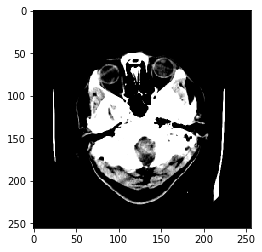

In [47]:
plt.imshow(dict_['image'][0,:,:], cmap='gray')
print(dict_['image'][0,:,:].max())

1.0


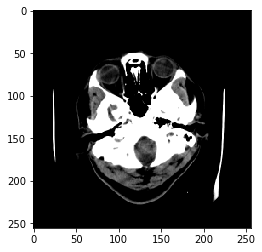

In [48]:
plt.imshow(dict_['image'][1,:,:], cmap='gray')
print(dict_['image'][1,:,:].max())

1.0


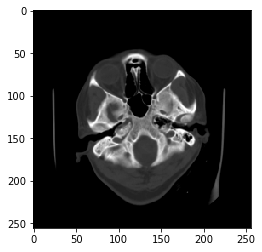

In [49]:
plt.imshow(dict_['image'][2,:,:], cmap='gray')
print(dict_['image'][2,:,:].max())

In [ ]:
dataSz = len(trainSet)
validation_split = 0.2
indices = list(range(dataSz))
split = int(np.floor(validation_split * dataSz))
shuffle_dataset = True

if shuffle_dataset:
    np.random.seed(0)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]